In [168]:
#Libraries
import numpy as np
from scipy.integrate import odeint, quad
from scipy.special import gamma
from scipy.constants import physical_constants as pc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


plt.style.use(['classic',"seaborn-v0_8-dark"])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mcolors.TABLEAU_COLORS)
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["legend.frameon"]=True
plt.rcParams['lines.linewidth'] = 1.5

In [169]:
# Fundamental Constants
G_F = pc['Fermi coupling constant'][0]*1e-18 # eV^2 
N_A = pc['Avogadro constant'][0] # mol-1
hbar = pc['reduced Planck constant'][0]/pc['electron volt'][0] # eV.s
c = pc['speed of light in vacuum'][0] # m.s-1

# Flavour Specific Constants
del_m2_31=2.5*1e-3
del_m2_21=7.53*1e-5
theta_31=np.arcsin(np.sqrt(2.18*1e-2))
theta_21=np.arcsin(np.sqrt(0.307))
R0 = 10 #km

# Conversion Factors
eV_to_1_by_m = pc['electron volt-inverse meter relationship'][0]
eV_to_1_by_km = eV_to_1_by_m*1e3
one_by_cm3_to_eV3 = (1.973*1e-5)**3
erg_to_MeV = 6.2415*1e5

In [170]:
# L vector
def L_vec(n_dim):
    if n_dim ==3:
        return np.array([0,0,1])
    raise ValueError("Dimension not defined")

# B vector
def B_vec(n_dim, theta):
    if n_dim == 3:
        return np.array([np.sin(2*theta), 0, -np.cos(2*theta)])
    raise ValueError("Dimension not defined")

In [171]:
# Neutrino-Neutrino Potential
def mu_r(r, opt, mu0=0):
    if opt == "SN":
        if r < R0:
            return mu0
        else:
            return 0.5*mu0*(R0/r)**4 #eV
    
    elif opt == "const":
        return mu0
    
    else:
        return ValueError("Invalid option chosen")
    
mu_vec = np.vectorize(mu_r)

In [172]:
# Matter Density Profile
def SN_density_profile(r, t):
    """
    Reference: https://arxiv.org/abs/hep-ph/0304056
    """
    r = np.array(r)
    rho0 = 1e14*r**(-2.4)  # g/cm³

    if t < 1:
        return rho0

    # Shockwave parameters
    epsilon = 10
    r_s0 = -4.6e3     # km
    v_s = 11.3e3      # km/s
    a_s = 0.2e3       # km/s²
    r_s = r_s0 + v_s* t + 0.5*a_s*t**2  # Shockwave position

    # Apply shockwave-modified profile where r <= r_s
    rho = rho0.copy()
    mask = r <= r_s
    with np.errstate(invalid='ignore'):
        a = (0.28 - 0.69*np.log(r[mask]))*(np.arcsin(1 - r[mask]/r_s)**1.1)
        rho[mask] *= epsilon*np.exp(a)

    return rho

In [173]:
# Electron density profile
def lambda_sn(r, option, n=N_A, t=1.0):
    m_n = pc['neutron mass'][0]*1e3 # g
    Y_e = 0.5  # electron fraction

    if option == "no":
        n_eff = 0
    elif option == "const":
        n_eff = n
    elif option == "SN":
        n_eff = (Y_e/m_n)*SN_density_profile(r, t)  # electrons per cm³
    else:
        raise ValueError("Invalid option for matter density profile. Choose 'no', 'const', or 'SN'.")

    return np.sqrt(2)*G_F*n_eff*one_by_cm3_to_eV3

In [174]:
def Multi_angle_rhs(y, r, params):
    omega, opt, mu0, l_option, l0, n_dim, u_vals, R = params
    N_u = len(u_vals)
    R2_by_r2 = R**2 / r**2

    v_u = np.sqrt(1 - u_vals * R**2 / r**2)  # shape (N_u,)

    # Extract B and L vectors
    B = np.array(B_vec(n_dim, theta_31))
    L = np.array(L_vec(n_dim))

    mu = mu_r(r, opt, mu0)
    l = lambda_sn(r, l_option, t=l0)

    # Reshape y into [2, N_u, n_dim] -- axis 0: P / P̄
    y = y.reshape(2, N_u, n_dim)
    P_nu = y[0]     # shape (N_u, n_dim)
    P_anu = y[1]
    P_r     = np.trapz(P_nu, u_vals, axis=0)     # shape (n_dim,)
    Pbar_r  = np.trapz(P_anu, u_vals, axis=0)

    # Self-interaction integral over u'
    integrand = (P_nu - P_anu) / v_u[:, None]  # shape (N_u, n_dim)
    integral = np.trapz(integrand, u_vals, axis=0)  # shape (n_dim,)
    H_self = mu*R2_by_r2*(P_r-Pbar_r)

    H_nu = np.abs(omega) * B + l * L + mu * R2_by_r2 *integral
    H_anu = -np.abs(omega) * B + l * L - mu * R2_by_r2 *integral
        
    dP_nu = np.cross(H_nu, P_nu) / v_u[:, None] - np.cross(H_self, P_nu)
    dP_anu = np.cross(H_anu, P_anu) / v_u[:, None] - np.cross(H_self, P_anu)

    dydr = np.concatenate([dP_nu, dP_anu], axis=0).flatten()
    return dydr


In [175]:
def Multi_angle_solver(P_init, E, r_i, r_f, mass_ord, opt, mu0, l_opt="no", l0=0, n_f=2, N_u=100, R=R0):
    n_dim = n_f**2 - 1
    omega = del_m2_31/(2*E*1e6)

    if mass_ord == "IH":
        omega *= -1
    elif mass_ord != "NH":
        raise ValueError("mass_ord must be 'NH' or 'IH'.")
    
    u_vals = np.linspace(0, 1, N_u)
    r_i = r_i * eV_to_1_by_km
    r_f = r_f * eV_to_1_by_km
    r_step = 5* eV_to_1_by_km
    r = np.arange(r_i, r_f, r_step)

    # Proper initialization: replicate for each angle bin and each flavor
    P_nu_init = np.tile(P_init, (N_u, 1))    # shape: (N_u, 3)
    P_anu_init = np.tile(P_init, (N_u, 1))   # shape: (N_u, 3)
    y0 = np.stack([P_nu_init, P_anu_init], axis=0).reshape(-1)  # shape: (2*N_u*n_dim,)

    params = (omega, opt, mu0, l_opt, l0, n_dim, u_vals, R)

    sol = odeint(Multi_angle_rhs, y0, r, args=(params,))
    sol = sol.reshape(-1, 2, N_u, n_dim)  # shape: (len(r), 2, N_u, n_dim)

    P_nu_all = sol[:, 0]    # shape: (len(r), N_u, 3)
    P_anu_all = sol[:, 1]

    return P_nu_all, P_anu_all, r/eV_to_1_by_km, u_vals


In [176]:
def Plot_Probability_MultiAngle(P_nu_NH, P_nu_IH, r, E, omega, mu0, u_vals):
    # Integrate over angle bins to get total polarization vectors
    P_r_vals_NH = np.trapz(P_nu_NH, u_vals, axis=1)   # shape: (len(r), 3)
    P_r_vals_IH = np.trapz(P_nu_IH, u_vals, axis=1)

    # Compute survival probabilities
    Pee_NH = 0.5 * (1 + P_r_vals_NH[:, 2])
    Pee_IH = 0.5 * (1 + P_r_vals_IH[:, 2])  # Normalize using NH[0] for fair comparison

    # Plot
    plt.figure(figsize=(8,5)) 
    plt.plot(r, Pee_NH, label='Normal Hierarchy')
    plt.plot(r, Pee_IH, ls='--', label='Inverted Hierarchy')

    plt.ylabel(r'$P_{\nu_e}$')
    plt.xlabel(r'$r$ [km]')
    plt.title(r'Survival Probability (Multi-Angle) — $E_{\nu}$ = %1.f MeV, $\omega$ = %.1e eV, $\mu_0$ = %.1e eV' % (E, omega, mu0))
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

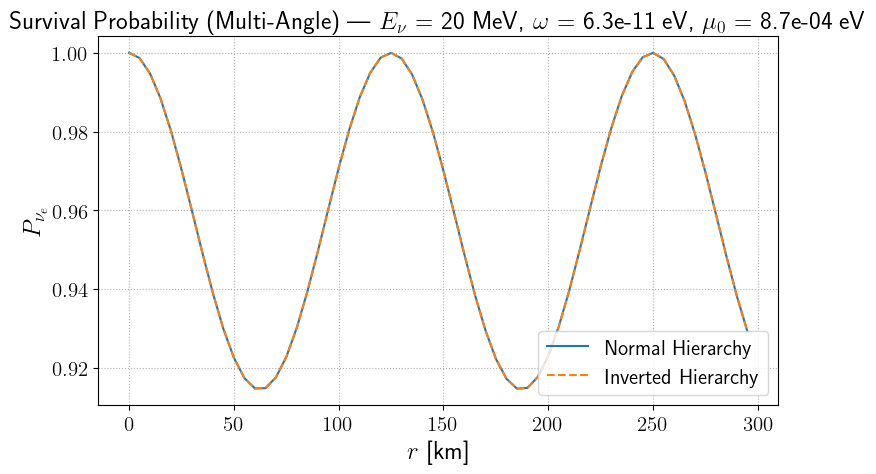

In [177]:
P_init = np.array([0, 0, 1]) 
E=20 #MeV
r_i,r_f=0.1,300#km
omega = del_m2_31/(2*E*1e6)
opt,mu0 ="const", 7e5/eV_to_1_by_km
l_opt = "const"

P_nu_IH,P_nubar_IH,r_IH,u_vals = Multi_angle_solver(P_init,E,r_i,r_f,"IH",opt,mu0,l_opt)
P_nu_NH,P_nubar_NH,r_NH,u_vals = Multi_angle_solver(P_init,E,r_i,r_f,"NH",opt,mu0,l_opt)
Plot_Probability_MultiAngle(P_nu_NH,P_nu_IH,r_NH,E,omega,mu0,u_vals)

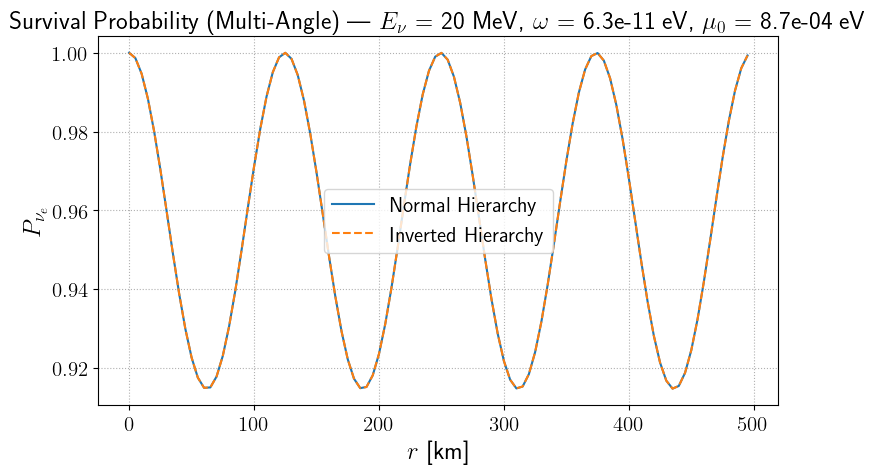

In [178]:
P_init = np.array([0, 0, 1]) 
E=20 #MeV
r_i,r_f=0.1,500 #km
omega = del_m2_31/(2*E*1e6)
omega_max = del_m2_31/(2*1e6)
opt,mu0 ="SN", 7e5/eV_to_1_by_km
l_opt = "SN"

P_nu_IH,P_nubar_IH,r_IH,u_vals = Multi_angle_solver(P_init,E,r_i,r_f,"IH",opt,mu0,l_opt)
P_nu_NH,P_nubar_NH,r_NH,u_vals = Multi_angle_solver(P_init,E,r_i,r_f,"NH",opt,mu0,l_opt)
Plot_Probability_MultiAngle(P_nu_NH,P_nu_IH,r_NH,E,omega,mu0,u_vals)